In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(interactions_train['watch_ratio'], bins=100, kde=True)
plt.show()


In [3]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


In [4]:
interactions_train['date'] = pd.to_datetime(interactions_train['date'])
interactions_train_filtered = interactions_train.sort_values('date').groupby(['user_id', 'video_id']).agg({
    'watch_ratio': 'last'  # ou moyenne pondérée par récence
}).reset_index()



In [5]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform')

interactions_train_filtered['rating'] = qt.fit_transform(interactions_train_filtered[['watch_ratio']])
interactions_test['rating'] = qt.transform(interactions_test[['watch_ratio']])

In [6]:
user_features = pd.read_csv("./KuaiRec 2.0/data/user_features.csv")
user_features.head()

,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,...,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,...,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,...,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,...,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,...,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,...,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
item_categories = pd.read_csv("./KuaiRec 2.0/data/item_categories.csv")
item_categories.head()

,video_id,feat
0,0,[8]
1,1,"[27, 9]"
2,2,[9]
3,3,[26]
4,4,[5]


In [8]:
# Exploser les listes dans la colonne 'feat' en lignes individuelles
item_categories['feat'] = item_categories['feat'].apply(eval)  # Convertir les chaînes en listes
exploded_feats = item_categories.explode('feat')

# Effectuer un encodage one-hot sur la colonne 'feat'
one_hot_encoded = pd.get_dummies(exploded_feats, columns=['feat'], prefix='feat')

# Agréger les résultats pour chaque 'video_id'
item_categories_one_hot = one_hot_encoded.groupby('video_id').sum().reset_index()

# Afficher le résultat
item_categories_one_hot.head()

,video_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# NNE

In [9]:
user_features_columns = ['user_id','onehot_feat0', 'onehot_feat1', 'onehot_feat2',
       'onehot_feat3', 'onehot_feat4', 'onehot_feat5', 'onehot_feat6',
       'onehot_feat7', 'onehot_feat8', 'onehot_feat9', 'onehot_feat10',
       'onehot_feat11', 'onehot_feat12', 'onehot_feat13', 'onehot_feat14',
       'onehot_feat15', 'onehot_feat16', 'onehot_feat17']

df_user_features = user_features[user_features_columns]
item_features_columns = ['video_id', 'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5',
       'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30']

df_item_features = item_categories_one_hot[item_features_columns]


In [10]:
df = interactions_train_filtered[['user_id', 'video_id', 'rating']].merge(df_user_features, on='user_id', how='left').merge(df_item_features, on='video_id', how='left')
df.head()

,user_id,video_id,rating,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,...,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30
0,0,42,0.701566,0,1,17,638,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,67,0.965087,0,1,17,638,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,80,0.745501,0,1,17,638,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,110,0.818220,0,1,17,638,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,128,0.781274,0,1,17,638,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
num_user_features = len(df_user_features.columns) - 1
num_item_features = len(df_item_features.columns) - 1

In [63]:
num_user_features, num_item_features

(18, 31)

In [58]:
from tensorflow.keras import layers, models

num_outputs = 64

user_NN = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(num_outputs)
])

item_NN = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(num_outputs)
])

user_input = layers.Input(shape=(num_user_features,))
item_input = layers.Input(shape=(num_item_features,))

vu = user_NN(user_input)
vm = item_NN(item_input)

concat = layers.Concatenate()([vu, vm])
x = layers.Dense(64, activation="relu")(concat)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)  # sortie dans [0,1]

model = models.Model([user_input, item_input], output)
model.compile(optimizer="adam", loss="mae", metrics=["mae"])


In [59]:
from tensorflow import keras

In [60]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanAbsoluteError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [61]:
X_user = df[user_features_columns].drop(columns=['user_id']).to_numpy()
X_item = df[item_features_columns].drop(columns=['video_id']).to_numpy()

In [62]:
model.fit(
    [X_user, X_item],
    df['rating'].values,
    batch_size=128,
    epochs=10,
    verbose=1,
)   

Epoch 1/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - loss: 0.2395 - mae: 0.2395
Epoch 2/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2415 - mae: 0.2415
Epoch 3/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 4/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 5/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 6/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 7/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 8/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 9/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492
Epoch 10/10
80477/80477 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.2492 - mae: 0.2492


In [52]:
print(f"Min:{df['rating'].min()} - Max:{df['rating'].max()} -  Mean:{df['rating'].mean()} - std:{df['rating'].std()}") 

Min:0.0 - Max:1.0 -  Mean:0.498046622463589 - std:0.2880288189815685


In [20]:
model.save_weights("model.weights.h5")

In [34]:
# Préparer les features utilisateur et item pour le jeu de test
X_user_test = interactions_test.merge(df_user_features, on='user_id', how='left')[user_features_columns].drop(columns=['user_id']).to_numpy()
X_item_test = interactions_test.merge(df_item_features, on='video_id', how='left')[item_features_columns].drop(columns=['video_id']).to_numpy()

# Prédire les ratings avec le modèle entraîné
# 1. Prédiction
y_pred_test = model.predict([X_user_test, X_item_test], batch_size=128, verbose=1)

# 2. DataFrame avec prédictions
df_pred = pd.DataFrame(y_pred_test, columns=['prediction'])

# 3. Ajout des colonnes originales (user_id, video_id, etc.)
df_pred = pd.concat([df_pred, interactions_test.reset_index(drop=True)], axis=1)


36536/36536 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step


In [35]:
df_pred.head()

,prediction,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,rating
0,0.589023,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,0.485410
1,0.566832,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0.909995
2,0.438025,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,0.928207
3,0.486266,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,0.389060
4,0.407858,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,0.301005


In [36]:
def evaluate_at_k(df, k, threshold=0.5):
    # Créer la colonne 'relevant' avant toute manipulation
    df['relevant'] = (df['rating'] > threshold).astype(int)

    # Trier les prédictions par utilisateur et score décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Ajouter le rang de chaque élément par utilisateur
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Garder le top-k par utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()  # Utiliser .copy() pour éviter la vue

    # Precision@k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Recall@k
    total_relevant_per_user = df[df['relevant'] == 1].groupby('user_id').size()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user

    # DCG@k
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # IDCG@k
    ideal = df.sort_values(by=['user_id', 'relevant'], ascending=[True, False])
    ideal['rank'] = ideal.groupby('user_id').cumcount() + 1
    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    ndcg = (dcg / idcg).fillna(0)

    # MAP@k
    def average_precision(group):
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    map_per_user = top_k.groupby('user_id')['relevant'].apply(lambda rel: average_precision(pd.DataFrame({'relevant': rel})))


    # Retourner les résultats sous forme de dictionnaire
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }



In [38]:
from sklearn.metrics import mean_absolute_error

mae_test = mean_absolute_error(df_pred['rating'], df_pred['prediction'])
print("MAE test:", mae_test)

MAE test: 0.19733529421333104


In [37]:
eval_results = evaluate_at_k(df_pred, k=10, threshold=0.9)
eval_results

{'precision': np.float64(0.2092133238837704),
 'recall': np.float64(0.01162603562589055),
 'ndcg': np.float64(0.22541779566112877),
 'map': np.float64(0.38530660479274265)}

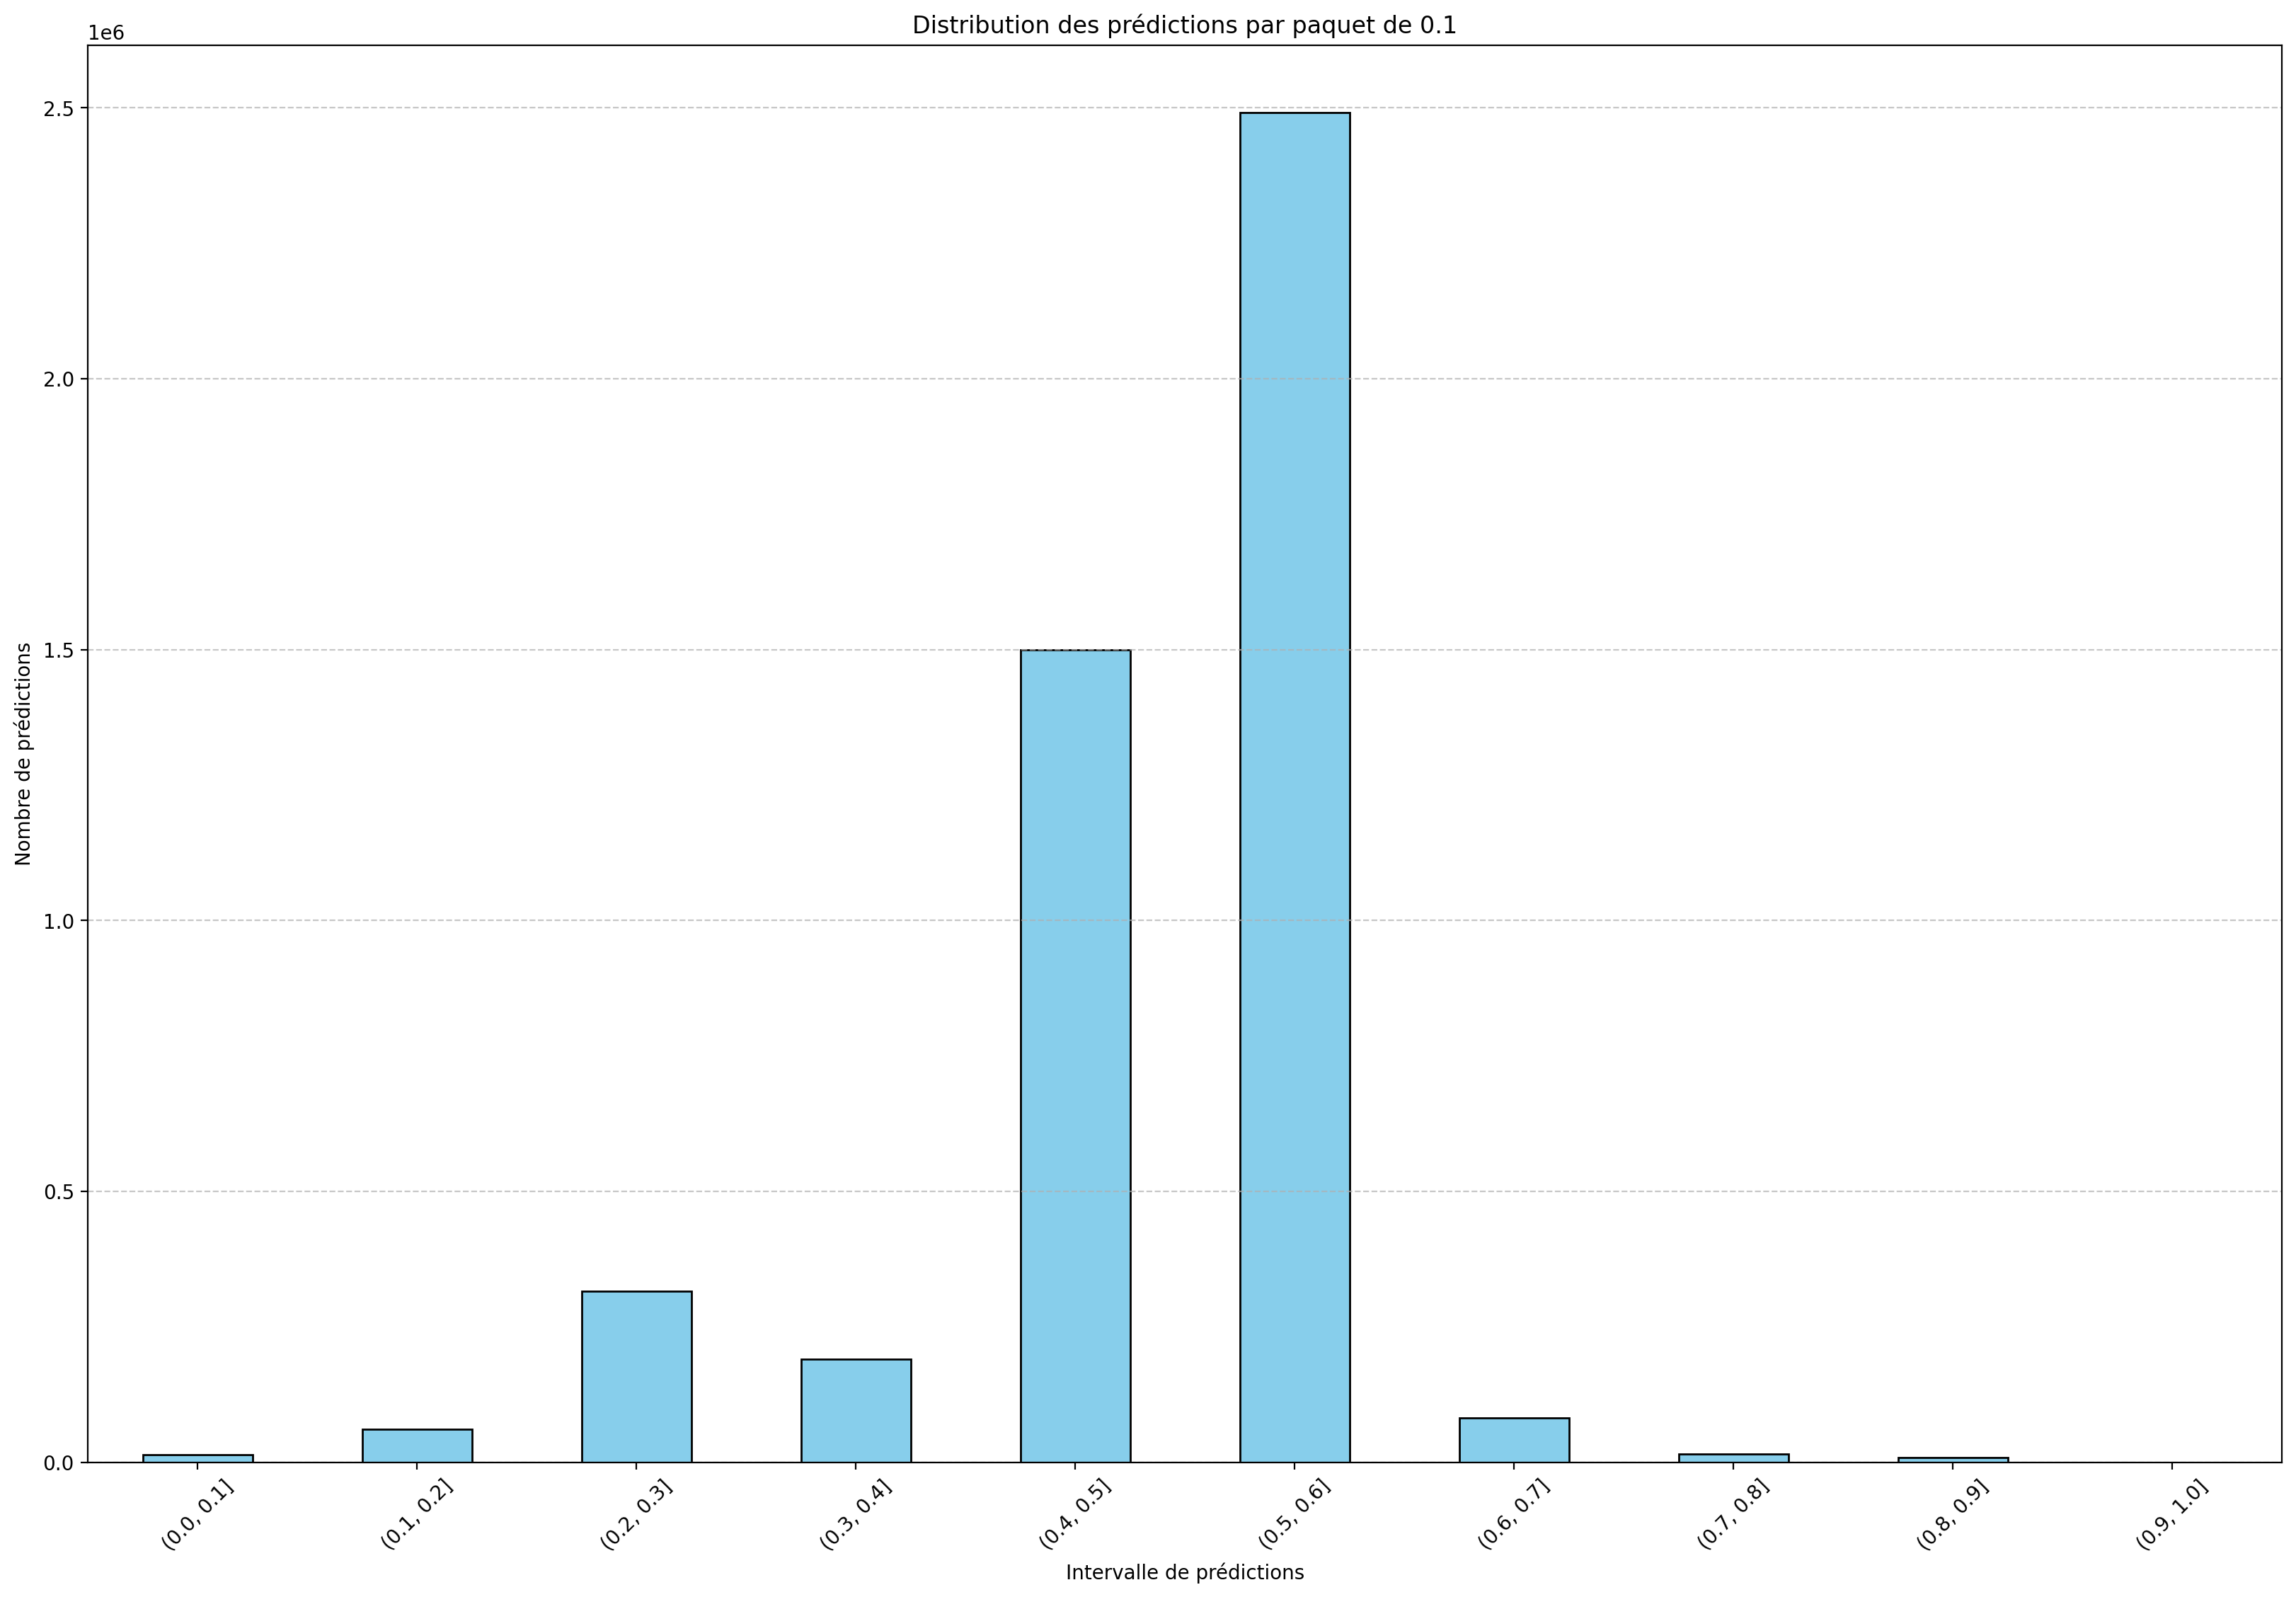

In [42]:
# Convertir les prédictions en pandas si ce n'est pas déjà fait
df_pred['prediction_bin'] = pd.cut(df_pred['prediction'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = df_pred['prediction_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des prédictions par paquet de 0.1")
plt.xlabel("Intervalle de prédictions")
plt.ylabel("Nombre de prédictions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

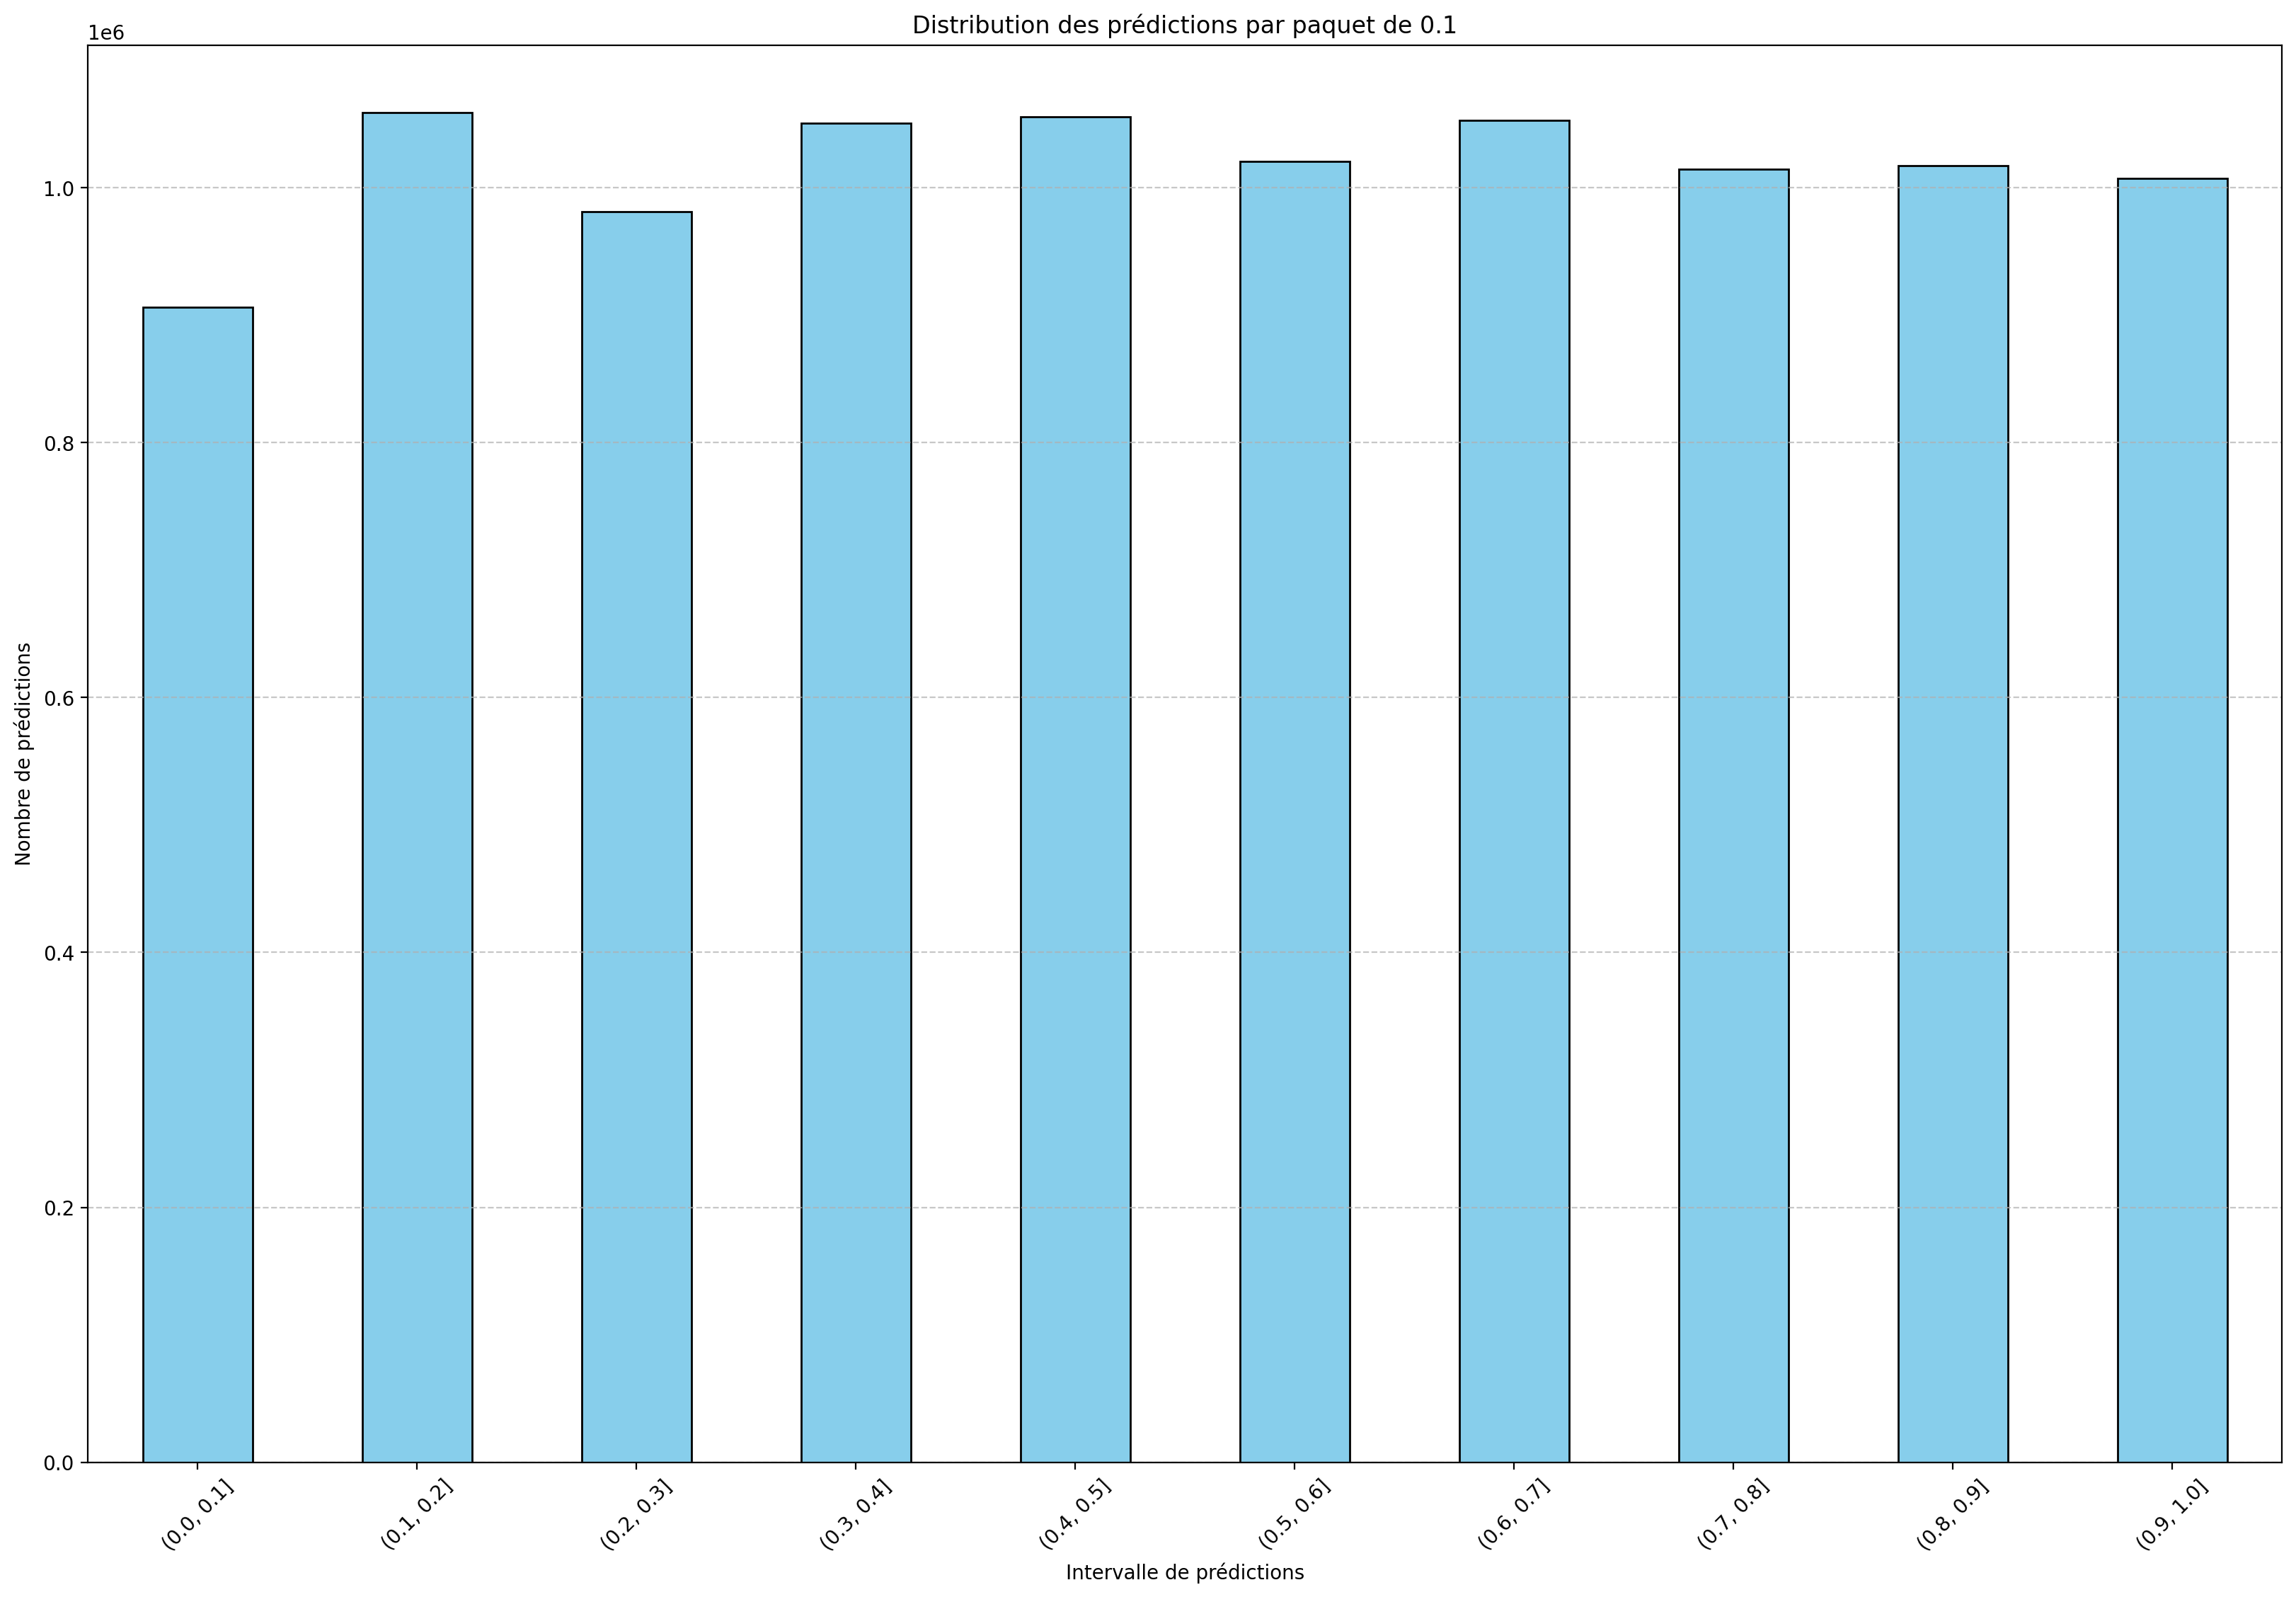

In [57]:
# Convertir les prédictions en pandas si ce n'est pas déjà fait
interactions_train_filtered['prediction_bin'] = pd.cut(interactions_train_filtered['rating'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_train_filtered['prediction_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des prédictions par paquet de 0.1")
plt.xlabel("Intervalle de prédictions")
plt.ylabel("Nombre de prédictions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()